### File descriptions
    sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.

    test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
    
    sample_submission.csv - a sample submission file in the correct format.
    
    items.csv - supplemental information about the items/products.

    item_categories.csv  - supplemental information about the items categories.

    shops.csv- supplemental information about the shops.

### Data fields
    
    > ID - an Id that represents a (Shop, Item) tuple within the test set
    
    > shop_id - unique identifier of a shop
    
    > item_id - unique identifier of a product
    
    > item_category_id - unique identifier of item category
    
    > item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
    
    > item_price - current price of an item
    
    > date - date in format dd/mm/yyyy
    
    > date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
    
    > item_name - name of item
    
    > shop_name - name of shop
    
    > item_category_name - name of item category

# first cut solution



.

### dependency

In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import pdb 

import time
from itertools import product
import warnings

import gc

from tqdm import tqdm

### Loading Data

In [3]:
sales_train = pd.read_csv('sales_train.csv')
test = pd.read_csv('test.csv')
sample_sub = pd.read_csv('sample_submission.csv')
items = pd.read_csv('items.csv')
item_cat = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')


In [4]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
#ques - create df with id, item, item_count 
gr = sales_train.groupby(['date_block_num','shop_id', 'item_id']).agg({ 'item_cnt_day':np.sum})


### data cleaning & preparation

observing in some 'item_cnt_day' contain -1 value 

In [6]:
# remove rows contain -1  
sales_train = sales_train[sales_train['item_cnt_day'] != -1]

<AxesSubplot:xlabel='item_price'>

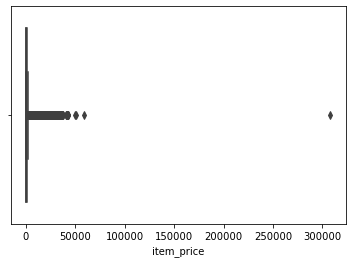

In [7]:
warnings.filterwarnings('ignore')


sns.boxplot(sales_train['item_price'])

 : item with more than 51k price there are 2 items are outlier 

<AxesSubplot:xlabel='item_cnt_day'>

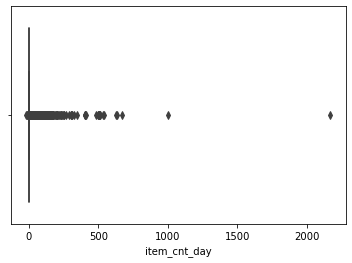

In [8]:


sns.boxplot(sales_train['item_cnt_day'])

items having more than 1000 'iten_cnt_day' are outlier 

In [9]:
# removing outlier 

sales_train = sales_train[sales_train['item_price'] <= 50000]
sales_train = sales_train[sales_train['item_cnt_day'] < 1000]



In [10]:
sales_train['date'] = pd.to_datetime(sales_train['date'])
temp_df = sales_train.copy()

temp_df['month_d'] = temp_df['date'].dt.to_period('M')
temp_df['year'] = temp_df['date'].dt.year

**wrt single shop we have 12 months in year 2013 where shop  - 'Якутск Орджоникидзе, 56 фран' id = 0 appears** 

In [11]:
#observation -  wrt single shop we have 12 months in year 2013 where shop  - 'Якутск Орджоникидзе, 56 фран' id = 0 appears 


temp_df2 = temp_df[temp_df['shop_id'] == 0].groupby(['year','month_d','item_id']).agg({'item_cnt_day':np.sum}).reset_index()
print(' month -\n',temp_df2['month_d'].unique())

print('\n years - ', temp_df2['year'].unique())


 month -
 <PeriodArray>
['2013-01', '2013-02', '2013-03', '2013-04', '2013-05', '2013-06', '2013-07',
 '2013-08', '2013-09', '2013-10', '2013-11', '2013-12']
Length: 12, dtype: period[M]

 years -  [2013]


**wrt sigle item,  we have only 4 months or in year 2014  where item  - 'ABBYY FineReader 12 Professional Edition ' id = 1 appears** 

In [12]:


temp_df2 = temp_df[temp_df['item_id'] == 1].groupby(['year','month_d','item_id']).agg({'item_cnt_day':np.sum}).reset_index()
print('month -',temp_df2['month_d'].unique())

print('\n years - ', temp_df2['year'].unique())


month - <PeriodArray>
['2014-02', '2014-04', '2014-06', '2014-10', '2014-11']
Length: 5, dtype: period[M]

 years -  [2014]


**data wrt sigle shop and single item**

In [13]:
# data wrt sigle shop and single item 

sales_train[(sales_train['shop_id'] == 0) & (sales_train['item_id'] == 35)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
40092,2013-01-31,0,0,35,247.0,1.0
173451,2013-01-02,1,0,35,247.0,1.0
173462,2013-02-02,1,0,35,247.0,2.0
173463,2013-06-02,1,0,35,247.0,2.0
173471,2013-04-02,1,0,35,247.0,1.0
173473,2013-02-24,1,0,35,247.0,1.0
173474,2013-02-16,1,0,35,247.0,1.0
173475,2013-02-15,1,0,35,247.0,1.0
173476,2013-02-14,1,0,35,247.0,1.0
173477,2013-10-02,1,0,35,247.0,1.0


**corresponding to every shop have unique number of items in overall data**

In [14]:
# # corresponding to every shop have unique number of item

num_of_item_per_shop = []
for i in range(59):
    num_of_item_per_shop.append(len(sales_train[sales_train['shop_id'] == i]['item_id'].unique()))
print(num_of_item_per_shop)

[3600, 2523, 4849, 5261, 7308, 7084, 11856, 8246, 1909, 1404, 6002, 371, 7374, 4865, 7451, 8269, 9372, 5158, 9072, 9558, 746, 10145, 7950, 2949, 8087, 15366, 9289, 10842, 12571, 7806, 9512, 14416, 3298, 1900, 1860, 9108, 258, 8404, 7355, 4096, 817, 7226, 12033, 6737, 8893, 7303, 9148, 7911, 4063, 3786, 9176, 8739, 8416, 7454, 13862, 1985, 11049, 12281, 8393]


conclusion
- 1 way is to crete pair of shop_id with all 22k item for each month
- another way is to create pair with only that item which pair exits in whole dateset (in all 35 month's data)


# 4. Embedding

In [15]:
# df['revenue'] = df['item_price'] *  df['item_cnt_day']
# df.head()

#### grouping data in monthly format

In [16]:
# each row is - month_year, shop_id, item_id
df = sales_train.groupby(['date_block_num', 'shop_id','item_id']).agg({'item_cnt_day':np.sum}).reset_index()
df.head()

,date_block_num,shop_id,item_id,item_cnt_day
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


## strategy


- now wrt to each shop and each item and each month , we will create of shop-item-date_block_num pair 
- then add lag features like lag feature, mean encoding
- other feature
- concatinate test data to matrix
- now will dump the matrix in data.pkl


#### creating matrix with all possible pairs 

In [25]:
item_ids = items['item_id']
shop_ids = shops['shop_id']
# sales_train['date_block_num'].unique()
month_d = list(range(34))

all_data = []

In [26]:
len(month_d), len(shop_ids), len(item_ids)

(34, 60, 22170)

#### creating data set with all possible unique pairs of   "shop - item- date_block_num pair"

In [27]:
%%time
# create dataset

data = np.array(list(product(month_d, shop_ids,item_ids)))
data.shape

Wall time: 1min 3s


(45226800, 3)

In [28]:
# %%time
# data = np.reshape(all_data, (-1,3) )

In [29]:
# %%time


# # creating table of dict value where key = (date,shop_id,item_id) and value = target

# def create_table(df):
#     table = {}
#     # convert d-type
#     df['month_d'] = df['month_d'].astype('str')
#     df_arr = np.array(df)
    
#     # df_arr is - df in array form
#     for i, row in enumerate(df_arr):
#         d,shop,item, i_cnt = row
#         table[(d,shop,item)] = i_cnt
    
#     return table

# table = create_table(df)



# #creating target/class variable for all pts in dateset

# target_itm_cnt = [] 
# for key in all_data:
    
#     key = tuple(key) 
#     value = 0
#     if key in table.keys():
#         value = table.get(key)
    
#     target_itm_cnt.append(value)


In [30]:
%%time

# converting array in dataframe

matrix =  pd.DataFrame({
    'date_block_num': np.reshape(data[:,[0]],(1,-1))[0],
    'shop_id': np.reshape(data[:,[1]],(1,-1))[0],
    'item_id': np.reshape(data[:,[2]],(1,-1))[0]
    
})

matrix.sort_values(['date_block_num','shop_id','item_id'])[:5]

Wall time: 20.8 s


,date_block_num,shop_id,item_id
0,0,0,0
1,0,0,1
2,0,0,2
3,0,0,3
4,0,0,4


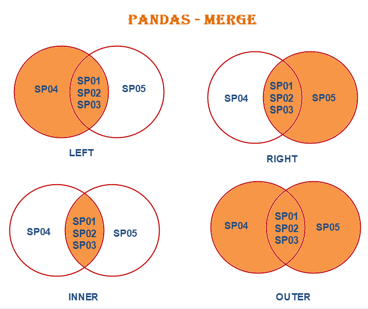

Merging target value wrt every row 

In [31]:
# merging target value wrt every row 

matrix = pd.merge(matrix, df, on=['date_block_num','shop_id','item_id'], how='left')
matrix['item_cnt_day'] = (matrix['item_cnt_day'].fillna(0).astype(np.float16).astype(np.float16))


In [32]:
matrix[:5]

,date_block_num,shop_id,item_id,item_cnt_day
0,0,0,0,0.0
1,0,0,1,0.0
2,0,0,2,0.0
3,0,0,3,0.0
4,0,0,4,0.0



#### test data

In [33]:

test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)


In [34]:
test.head()

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34


**concatnating 'test' data to main 'matrix'**

In [35]:
%%time

matrix = pd.concat([matrix, test], ignore_index=True ,sort=False, keys=['date_block_num','shop_id','item_id'])
matrix.fillna(0, inplace=True) # 34 month


Wall time: 1.35 s


In [36]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(df.item_id)))), len(list(set(test.item_id))), len(test)

(363, 5100, 214200)

## adding  features

**lag feature** - 

A lag features is a fancy name for a variable which contains data from prior time steps. 
If we have time-series data, we can convert it into rows.
Every row contains data about one observation and includes all previous occurrences of 
that observation.



refer - https://www.mikulskibartosz.name/forecasting-time-series-using-lag-features/



In [38]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [39]:
%%time

matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_day')


Wall time: 3min 19s


In [40]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_day,ID,item_cnt_day_lag_1,item_cnt_day_lag_2,item_cnt_day_lag_3,item_cnt_day_lag_6,item_cnt_day_lag_12
0,0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,0,0,1,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,0,0,2,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,0,0,3,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,0,0,4,0.0,0.0,NaN,NaN,NaN,NaN,NaN


#### Mean encoded features
...

In [41]:
%%time
# reference - https://www.kaggle.com/code/dlarionov/feature-engineering-xgboost#Part-2,-xgboost

group = matrix.groupby(['date_block_num']).agg({'item_cnt_day': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)

Wall time: 53.6 s


In [42]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_day,ID,item_cnt_day_lag_1,item_cnt_day_lag_2,item_cnt_day_lag_3,item_cnt_day_lag_6,item_cnt_day_lag_12,date_avg_item_cnt_lag_1
0,0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,2,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,3,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,4,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
%%time
# reference - https://www.kaggle.com/code/dlarionov/feature-engineering-xgboost#Part-2,-xgboost

group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_day': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

Wall time: 3min 28s


In [44]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_day,ID,item_cnt_day_lag_1,item_cnt_day_lag_2,item_cnt_day_lag_3,item_cnt_day_lag_6,item_cnt_day_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12
0,0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,2,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,3,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,4,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
%%time
# reference - https://www.kaggle.com/code/dlarionov/feature-engineering-xgboost#Part-2,-xgboost

group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_day': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

Wall time: 4min 51s


In [48]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_day,ID,item_cnt_day_lag_1,item_cnt_day_lag_2,item_cnt_day_lag_3,item_cnt_day_lag_6,item_cnt_day_lag_12,...,date_shop_avg_item_cnt_lag_1_x,date_shop_avg_item_cnt_lag_2_x,date_shop_avg_item_cnt_lag_3_x,date_shop_avg_item_cnt_lag_6_x,date_shop_avg_item_cnt_lag_12_x,date_shop_avg_item_cnt_lag_1_y,date_shop_avg_item_cnt_lag_2_y,date_shop_avg_item_cnt_lag_3_y,date_shop_avg_item_cnt_lag_6_y,date_shop_avg_item_cnt_lag_12_y
0,0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,2,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,3,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,4,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
%%time
# reference - https://www.kaggle.com/code/dlarionov/feature-engineering-xgboost#Part-2,-xgboost

# group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
# group.columns = [ 'date_cat_avg_item_cnt' ]
# group.reset_index(inplace=True)

# matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
# matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
# matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
# matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

In [49]:
matrix['month'] = matrix['date_block_num'] % 12

In [50]:
matrix.head()      

,date_block_num,shop_id,item_id,item_cnt_day,ID,item_cnt_day_lag_1,item_cnt_day_lag_2,item_cnt_day_lag_3,item_cnt_day_lag_6,item_cnt_day_lag_12,...,date_shop_avg_item_cnt_lag_2_x,date_shop_avg_item_cnt_lag_3_x,date_shop_avg_item_cnt_lag_6_x,date_shop_avg_item_cnt_lag_12_x,date_shop_avg_item_cnt_lag_1_y,date_shop_avg_item_cnt_lag_2_y,date_shop_avg_item_cnt_lag_3_y,date_shop_avg_item_cnt_lag_6_y,date_shop_avg_item_cnt_lag_12_y,month
0,0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,0,0,1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,0,0,2,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,0,0,3,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,0,0,4,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [51]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

# 5. final preparation 

Because of the using 12 as lag value drop first 12 months. Also drop all the columns with this month calculated values (other words which can not be calcucated for the test set)

In [52]:

matrix = matrix[matrix.date_block_num > 11]

creating lags feature brings a lot of nulls.

In [53]:
%%time

def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)

Wall time: 1.94 s


In [54]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_day', 'ID',
       'item_cnt_day_lag_1', 'item_cnt_day_lag_2', 'item_cnt_day_lag_3',
       'item_cnt_day_lag_6', 'item_cnt_day_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1_x',
       'date_shop_avg_item_cnt_lag_2_x', 'date_shop_avg_item_cnt_lag_3_x',
       'date_shop_avg_item_cnt_lag_6_x', 'date_shop_avg_item_cnt_lag_12_x',
       'date_shop_avg_item_cnt_lag_1_y', 'date_shop_avg_item_cnt_lag_2_y',
       'date_shop_avg_item_cnt_lag_3_y', 'date_shop_avg_item_cnt_lag_6_y',
       'date_shop_avg_item_cnt_lag_12_y', 'month', 'days'],
      dtype='object')

In [55]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29478600 entries, 15962400 to 45440999
Data columns (total 28 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   date_block_num                   int32  
 1   shop_id                          int32  
 2   item_id                          int32  
 3   item_cnt_day                     float16
 4   ID                               float64
 5   item_cnt_day_lag_1               float16
 6   item_cnt_day_lag_2               float16
 7   item_cnt_day_lag_3               float16
 8   item_cnt_day_lag_6               float16
 9   item_cnt_day_lag_12              float16
 10  date_avg_item_cnt_lag_1          float16
 11  date_item_avg_item_cnt_lag_1     float16
 12  date_item_avg_item_cnt_lag_2     float16
 13  date_item_avg_item_cnt_lag_3     float16
 14  date_item_avg_item_cnt_lag_6     float16
 15  date_item_avg_item_cnt_lag_12    float16
 16  date_shop_avg_item_cnt_lag_1_x   float16
 17 

In [ ]:
matrix.to_pickle('data.pkl')


In [74]:
del matrix
del df
del data
gc.collect();

NameError: name 'data' is not defined

In [17]:
data = pd.read_pickle('data.pkl')

In [18]:
data = data[['date_block_num', 'shop_id', 'item_id', 'item_cnt_day',
       'item_cnt_day_lag_1', 'item_cnt_day_lag_2', 'item_cnt_day_lag_3',
       'item_cnt_day_lag_6', 'item_cnt_day_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'month', 'days']]

In [19]:
data.head()

,date_block_num,shop_id,item_id,item_cnt_day,item_cnt_day_lag_1,item_cnt_day_lag_2,item_cnt_day_lag_3,item_cnt_day_lag_6,item_cnt_day_lag_12,date_avg_item_cnt_lag_1,...,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,month,days
0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,31
1,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,31
2,0,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,31
3,0,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,31
4,0,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,31


Validation strategy is 34 month for the test set, 33 month for the validation set and 13-33 months for the train.



In [20]:
# reducing size
data = data[data.date_block_num > 20] 

In [21]:
data.shape

(17506800, 22)

In [22]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_day'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_day']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_day'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_day']
X_test = data[data.date_block_num == 34].drop(['item_cnt_day'], axis=1)

In [23]:
X_train.shape, X_valid.shape,X_test.shape

((15962400, 21), (1330200, 21), (214200, 21))

In [24]:
# del data
gc.collect()

154

# 6. Model training and evalution

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor


In [122]:
# linear regression

model1 = LinearRegression()
model1 = model1.fit(X_train,Y_train)

y_pred_cv = model1.predict(X_valid)

rmse = mean_squared_error(Y_valid,y_pred_cv)
rmse

1.7049025438970822

In [130]:
%%time
# decision tree - without hyperparameter tuning

model2 = GradientBoostingRegressor(max_depth=6)
model2.fit(X_train,Y_train)


Wall time: 2h 6min 29s


GradientBoostingRegressor(max_depth=6)

In [131]:
y_pred_cv3 = model2.predict(X_valid)

rmse = mean_squared_error(Y_valid,y_pred_cv3)
rmse

2.9738117614808166

In [27]:
%%time
#XGBregressor
# reference - https://www.kaggle.com/code/dlarionov/feature-engineering-xgboost#Part-2,-xgboost

from xgboost import XGBRegressor

model = XGBRegressor(
    max_depth=8,
    n_estimators=100,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit( X_train,Y_train, eval_metric="rmse", eval_set=[(X_valid, Y_valid)], verbose=False, early_stopping_rounds = 10)
    

Wall time: 2min 50s


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.3,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=300,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, ...)

In [115]:
y_pred_cv_2 = model.predict(X_valid)

rmse = mean_squared_error(Y_valid,y_pred_cv_2)
rmse

(0.82608783, 207.9951286315918)

...
<!-- 
**rolling window**

in rolling window operation we perform statistic operation on the moving window where
window represent range and statistic operation are mean, median, mode , min, max etc
pandas provide rolling() which provide rolling window calculations gives values at each time stamp.

refer- https://medium.com/data-science-at-microsoft/introduction-to-feature-engineering-for-time-series-forecasting-620aa55fcab0 -->